Hi! I will explain a bit what I have done for this problem. 

It is a problem which can go to a very high complexity given the amount of parameters and data available. Therefore, some assumptions or simplifications have been made, in order to limit the problem. 

As a first check, I wish to only plot the ECG's in order to get an idea of how they look. 


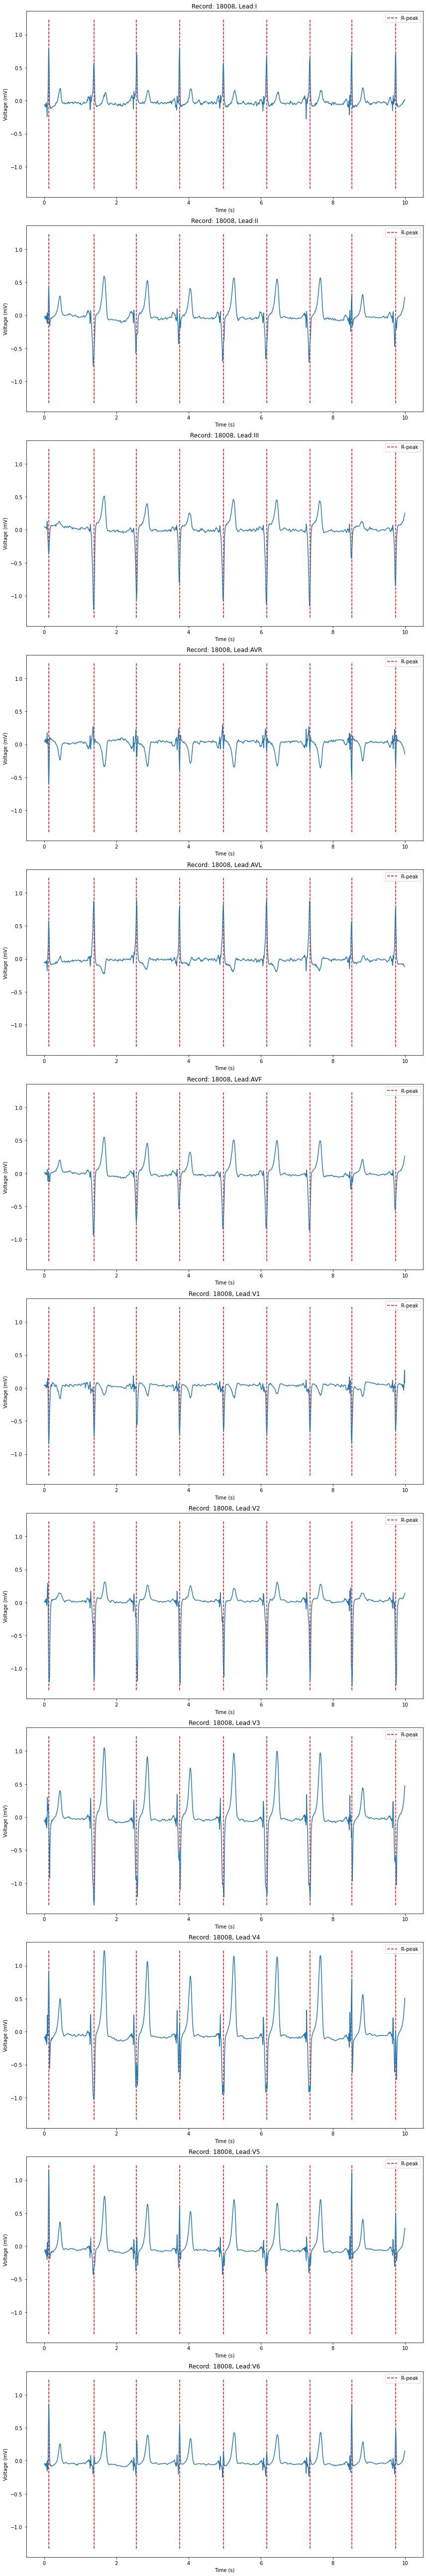

In [1]:

import wfdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re

#Choose a random signal from the dataset
record_number = str("{:02d}".format(random.randint(0,21837))) 
path = '/Users/mikaelkindblom/physionet.org/files/ptb-xl/1.0.2/'

record_name = 'records100/' + record_number[0:2] + '000/' + record_number + '_lr'
record = wfdb.rdrecord(path + record_name)

# Read the metadata CSV file
metadata_file = path + 'ptbxl_database.csv'
metadata_df = pd.read_csv(metadata_file)

# Find the index of the record in the metadata using the filename
record_idx = metadata_df[metadata_df['filename_lr'] == record_name].index[0]

# Get the R-peaks from the metadata for the specific record
r_peaks_str = metadata_df.loc[record_idx, 'r_peaks']
r_peaks = list(map(int, re.findall(r'\d+', r_peaks_str)))

# Get all ECG signal data from the record
ecg_data = record.p_signal

# Get the sampling frequency from the record
sampling_frequency = record.fs

# Create a time axis based on the sampling frequency
num_samples = ecg_data.shape[0]
time = np.linspace(0, (num_samples - 1) / sampling_frequency, num_samples)

# Plot all 12 ECG leads in separate subplots
num_leads = ecg_data.shape[1]
plt.figure(figsize=(12, 6 * num_leads))
lead_code = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# Use the same r_peaks for all subplots
r_peak_times = np.array(r_peaks) / sampling_frequency

for lead_idx in range(num_leads):
    plt.subplot(num_leads, 1, lead_idx + 1)
    plt.plot(time, ecg_data[:, lead_idx])

    # Annotate R-peaks with vertical lines
    plt.vlines(r_peak_times, ymin=np.min(ecg_data), ymax=np.max(ecg_data), colors='r', linestyles='--', label='R-peak')
    
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (mV)')
    plt.title('Record: ' + record_number + ', Lead:'+ lead_code[lead_idx])
    plt.legend() 

plt.tight_layout()
plt.show()


As there were no information on what lead the correct labels for the R-peaks are found, I assume that they are all coinciding over all 12 leads. From just visually inspecting, I choose to the V5 lead as reference lead for the R-peak.

The following code applies a Butterworth passband filter to the signal in order to filter out irrelevant information in the signal that might disturb the peak detection model. 
It is primarily remove the smaller frequencies that gives rise to the wavy behaviour of certain signals. However, it has to be very low in order to not interfere with the R-peaks in the signal. 

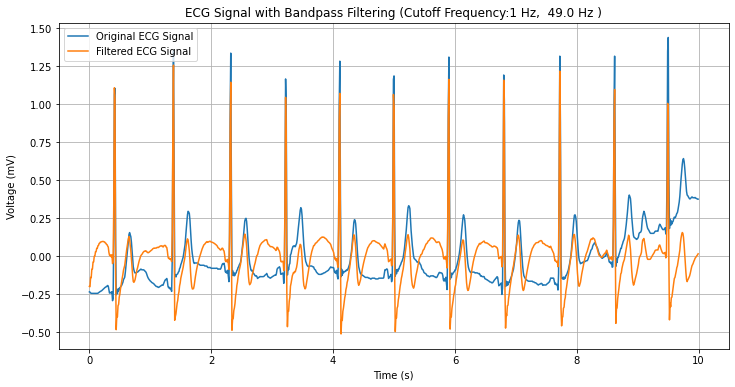

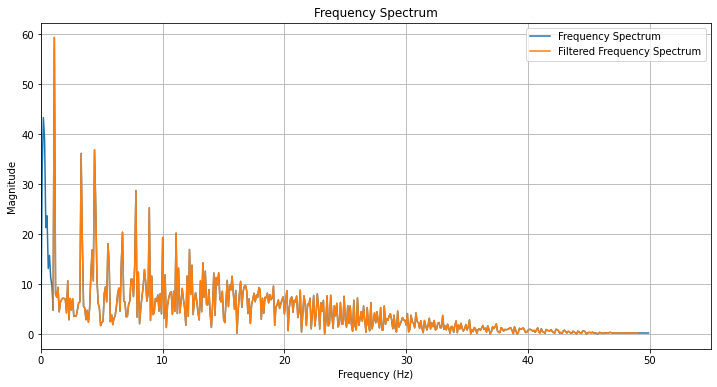

In [2]:
from scipy.signal import butter, lfilter

record_number = '13857'
path = '/Users/mikaelkindblom/physionet.org/files/ptb-xl/1.0.2/'
record_name = 'records100/' + record_number[0:2] + '000/' + record_number + '_lr'
record = wfdb.rdrecord(path + record_name)

# Get the ECG signal data from the record
ecg_data = record.p_signal[:, 10]  # 
# Get the sampling frequency from the record
sampling_frequency = record.fs

# Create a time axis based on the sampling frequency
num_samples = len(ecg_data)
time = np.linspace(0, (num_samples - 1) / sampling_frequency, num_samples)


# Passband filter parameters
lowcut = 1
highcut = 49.0
order = 4

# Design the passband filter using Butterworth
low = lowcut / (0.5 * sampling_frequency)
high = highcut / (0.5 * sampling_frequency)
b, a = butter(order, [low, high], btype='band')

# Apply the passband filter to the ECG signal
filtered_ecg_data = lfilter(b, a, ecg_data)

# Plot the original and filtered ECG waveforms
plt.figure(figsize=(12, 6))
plt.plot(time, ecg_data, label='Original ECG Signal')
plt.plot(time, filtered_ecg_data, label='Filtered ECG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('ECG Signal with Bandpass Filtering (Cutoff Frequency:' + str(lowcut) + ' Hz,  ' + str(highcut) + ' Hz )')
plt.legend()
plt.grid()
 
# Perform the Fast Fourier Transform (FFT) on the ECG signal
fft_result = np.fft.fft(ecg_data)
magnitude_spectrum = np.abs(fft_result)
frequencies = np.fft.fftfreq(num_samples, d=1/sampling_frequency)

# Keep only the positive frequencies
positive_frequencies_mask = frequencies >= 0
frequencies = frequencies[positive_frequencies_mask]
magnitude_spectrum = magnitude_spectrum[positive_frequencies_mask]

#Filtered by the butterworth filter
filter_mask = np.logical_and(frequencies >= lowcut, frequencies <= highcut)
frequencies_filtered = frequencies[filter_mask]
magnitude_spectrum_filtered = magnitude_spectrum[filter_mask]

# Plot the frequency spectrum
plt.figure(figsize=(12, 6))
plt.plot(frequencies, magnitude_spectrum, label='Frequency Spectrum')
plt.plot(frequencies_filtered, magnitude_spectrum_filtered, label='Filtered Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum')
#Nyquist theorem - for 100Hz, 50Hz is the highest frequency we can see
plt.xlim(0, 55)  # Limit the x-axis to 0 to 55 Hz
plt.legend()
plt.grid()

plt.show()




The following code prepares the data (the V5 lead) for the ML model to predict the R-peaks. I have chosen to see this as a supervised problem where I train with the given r-peaks as labels. However, as they are not all of same size (which complicates the problem), I made them equal size by binarizing the peak vector such that each of the 1000 points is either 1 (peak) or 0 (no peak). I also apply the Butterworth filter defined in previous cell.  

In [3]:
import os
import glob


# Replace 'your_directory_path' with the path to the directory containing the ECG records
directory_path = '/Users/mikaelkindblom/physionet.org/files/ptb-xl/1.0.2/records100/'

# Read the metadata CSV file
metadata_file = '/Users/mikaelkindblom/physionet.org/files/ptb-xl/1.0.2/ptbxl_database.csv'
metadata_df = pd.read_csv(metadata_file)

# Get the list of subdirectories inside 'directory_path'
subdirectories = glob.glob(os.path.join(directory_path, '[0-9]*'))

# Prepare the data and metadata
X_data = []
y_data = []
fold_suggestion = []
signal_counter=0

# Loop through each subdirectory and process the records
for subdirectory in subdirectories:
    # Get the list of record names in the subdirectory matching the pattern '*_lr.dat' recursively
    record_names_in_subdir = glob.glob(os.path.join(subdirectory, '**', '*_lr.dat'), recursive=True)
    print("Loading subdirectory:" + subdirectory + "......")
    if record_names_in_subdir:
        # Process each record in the subdirectory
        for record_path in record_names_in_subdir:
            
            # Extract the base filename without the extension
            record_name_without_extension = os.path.splitext(os.path.basename(record_path))[0]

            # Check if the corresponding .hea file exists for the record
            record_hea_file = os.path.join(subdirectory, record_name_without_extension + '.hea')
            if not os.path.exists(record_hea_file):
                print(f"Warning: .hea file not found for record: {record_name_without_extension}")
                continue

            # Load the ECG record
            record = wfdb.rdrecord(os.path.join(subdirectory, record_name_without_extension))
            # Get the ECG signal data from the record
            ecg_data = record.p_signal[:, 10]  # Assuming the first column contains the ECG data

            # Get the sampling frequency from the record
            sampling_frequency = record.fs

            # Create a time axis based on the sampling frequency
            num_samples = len(ecg_data)
            time = np.linspace(0, (num_samples - 1) / sampling_frequency, num_samples)

            # Get the metadata for the current record
            metadata_row = metadata_df[metadata_df['filename_lr'].str.contains(os.path.basename(record_name_without_extension))]

            if metadata_row.empty:
                print(f"Warning: No metadata found for record: {record_name_without_extension}")
                continue

            # Extract the peak locations
            r_peaks_str = metadata_row['r_peaks'].iloc[0]
            
            # Extract the fold information
            fold_suggestion.append(metadata_row['strat_fold'].iloc[0])

            # Modify the format of the string to a valid Python list format
            r_peaks_str = r_peaks_str.replace('[', '').replace(']', '')  # Remove brackets
            r_peaks_list = r_peaks_str.split()  # Split the string into individual numbers as strings

            # Convert the list of strings to a list of integers
            peak_locations = np.array([int(peak) for peak in r_peaks_list])

            # Convert the peak locations to a binary label indicating the presence of a peak in each time step
            labels = np.zeros(len(ecg_data), dtype=int)  # Initialize label vector with zeros
            labels[peak_locations] = 1  # Set peak locations to 1

            # Get the selected metadata
            
            sex = metadata_row['sex'].iloc[0]
            
            from scipy.signal import butter, lfilter

            # Apply the passband filter to the ECG signal
            filtered_ecg_data = lfilter(b, a, ecg_data)

            # Append the ECG data and peak labels to the lists
            X_data.append(filtered_ecg_data)
            y_data.append(labels)
            # Print progress after every 1000 signals
            if signal_counter % 1000 == 0:
                print(f"Loaded {signal_counter} signals")
            signal_counter += 1


Loading subdirectory:/Users/mikaelkindblom/physionet.org/files/ptb-xl/1.0.2/records100/00000......
Loaded 0 signals
Loading subdirectory:/Users/mikaelkindblom/physionet.org/files/ptb-xl/1.0.2/records100/10000......
Loaded 1000 signals
Loading subdirectory:/Users/mikaelkindblom/physionet.org/files/ptb-xl/1.0.2/records100/04000......
Loaded 2000 signals
Loading subdirectory:/Users/mikaelkindblom/physionet.org/files/ptb-xl/1.0.2/records100/14000......
Loaded 3000 signals
Loading subdirectory:/Users/mikaelkindblom/physionet.org/files/ptb-xl/1.0.2/records100/20000......
Loaded 4000 signals
Loading subdirectory:/Users/mikaelkindblom/physionet.org/files/ptb-xl/1.0.2/records100/05000......
Loaded 5000 signals
Loading subdirectory:/Users/mikaelkindblom/physionet.org/files/ptb-xl/1.0.2/records100/15000......
Loaded 6000 signals
Loading subdirectory:/Users/mikaelkindblom/physionet.org/files/ptb-xl/1.0.2/records100/21000......
Loaded 7000 signals
Loading subdirectory:/Users/mikaelkindblom/physione

The following code creates a simple neural network and trains on the data. The model has an input layer, an output layer, and 2 hidden layers. 

As explained in the preparation stage, the ground truth labels are sequences of 1000 binary values. As I did not find a way to have both an input layer and output layer of 1000 neurons using binary crossentropy, I instead feed sequences of 1000 points through each neuron in the network. This approach treats each label as an independent binary classification problem, even though you have a single output neuron. 

I tried some different network shapes but it has a limited effect on performance.


Note: I did not store any weights as the network trains very quickly. 

In [25]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.optimizers import Adam



# Convert lists to numpy arrays
X = np.array(X_data, dtype=np.float32)
y = np.array(y_data, dtype=np.float32)

# Define the model
model = Sequential()
model.add(InputLayer(input_shape=(1000,1))),
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

# Print the model summary
model.summary()

for assigned_fold in range(1, 11):
    print(f"Training on fold {assigned_fold}...")

    train_index = np.where(np.array(fold_suggestion) != assigned_fold)[0]
    validation_index = np.where(np.array(fold_suggestion) == 9)[0]
    test_index = np.where(np.array(fold_suggestion) == 10)[0]

    X_train = X[train_index]
    y_train = y[train_index]
    X_validation = X[validation_index]
    y_validation = y[validation_index]
    X_test = X[test_index]
    y_test = y[test_index]


    # Train the model
    model.fit(X_train, y_train, epochs=1, batch_size=10)
    
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    loss = model.evaluate(X_test, y_test)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 1000, 32)          64        
                                                                 
 dense_28 (Dense)            (None, 1000, 64)          2112      
                                                                 
 dense_29 (Dense)            (None, 1000, 1)           65        
                                                                 
Total params: 2241 (8.75 KB)
Trainable params: 2241 (8.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training on fold 1...
69/69 [==============================] - 2s 20ms/step - loss: 0.0320
Training on fold 2...
69/69 [==============================] - 1s 12ms/step - loss: 0.0321
Training on fold 3...
69/69 [==============================] - 1s 12ms/step - loss: 0.0321
Training on f

The model worked fairly well so I stuck with this solution. However, I recognize that it is not an intelligent network. If I would do the challenge again, I would have liked to use for example a LSTM network, where one or a few data points go through network sequencially and the network can learn to understand the notion of time and periodicity that an ECG has.  

In the following cell I make a prediction on a random sample of the test set. In order to get good predictions I have thresholded the continous predictions lower than the typical 0.5 (Bigger than 0.5 - peak, Smaller than 0.5 - no peak)
Setting it lower will create more false positives, but generally only around the actual peak. Therefore I created a small algortihm which checks that in case several immediately adjacent peaks are found - select the one with the highest value. 

The performance of the model is measured through f1-score. As there is not clear whether FP, FN, TP or TN bear more or less importance, f1 score is a good measure to incorporate them all. 

Note: The f1 score is measured on the signal assuming that it's annotated at a 1/100 of a second precision. The annotation of the signal probably doesn't have that precision, and furthermore, it's not even defined what lead the R-peaks are measured from. Therefore, the actual score might be higher than measured as my model might find immediately adjacent points to the correct labels.

In [26]:
from sklearn.metrics import f1_score

# Binary threshold
binary_threshold=0.04
# Number of adjacent candidate peaks to compare
num_timesteps = 4

def get_highest_peak_indices(data, indices, num_timesteps):
    highest_peak_indices = []
    
    for i in indices:
        peak_value = data[i]
        
        left_start = max(0, i - num_timesteps)
        left_end = i
        left_neighbor_values = data[left_start:left_end]
        
        right_start = i + 1
        right_end = min(len(data), i + num_timesteps + 1)
        right_neighbor_values = data[right_start:right_end]
        
        if (not left_neighbor_values.any() or peak_value >= np.max(left_neighbor_values)) and \
           (not right_neighbor_values.any() or peak_value >= np.max(right_neighbor_values)):
            highest_peak_indices.append(i)
    
    return highest_peak_indices

# Initialize a list to store F1 scores for each time step
f1_scores = []
# Loop through each time step
for i in range(y_test.shape[0]):
        predictions = model.predict(X_test[i].reshape(-1, 1), verbose=0)

        # Convert the continuous predictions to binary using a threshold
        index_vector = np.where(predictions > binary_threshold)[0]
        highest_peak_indices = get_highest_peak_indices(predictions.flatten(), index_vector, num_timesteps)

        # Update binary predictions based on post-processing
        binary_predictions = np.zeros_like(predictions)
        binary_predictions[highest_peak_indices] = 1

        # Reshape binary predictions for comparison with y_test
        binary_predictions_reshaped = binary_predictions.reshape(-1)

        # Calculate the F1 score for the current time step and sample
        f1 = f1_score(y_test[i], binary_predictions_reshaped, zero_division=1)

        # Append the F1 score to the list
        f1_scores.append(f1)
        if i%100 == 0 and i!=0:
            print('Evaluated performance of ' + str(i) + ' out of ' + str(y_test.shape[0]) + ' test samples')
            # Calculate the average F1 score
            avg_f1_score = sum(f1_scores) / len(f1_scores)
            # Print the aggregated F1 score after the loop
            print(f"Average F1 Score: {avg_f1_score}")
            
print(f"Average F1 Score: {avg_f1_score}")

Evaluated performance of 100 out of 2197 test samples
Average F1 Score: 0.7397964560898855
Evaluated performance of 200 out of 2197 test samples
Average F1 Score: 0.7274160973403635
Evaluated performance of 300 out of 2197 test samples
Average F1 Score: 0.7249419450995601
Evaluated performance of 400 out of 2197 test samples
Average F1 Score: 0.7279483196230506
Evaluated performance of 500 out of 2197 test samples
Average F1 Score: 0.7205688269697224
Evaluated performance of 600 out of 2197 test samples
Average F1 Score: 0.7315934635615226
Evaluated performance of 700 out of 2197 test samples
Average F1 Score: 0.7241113505097697
Evaluated performance of 800 out of 2197 test samples
Average F1 Score: 0.7278036328226729
Evaluated performance of 900 out of 2197 test samples
Average F1 Score: 0.7337689916683965
Evaluated performance of 1000 out of 2197 test samples
Average F1 Score: 0.7274180961315454
Evaluated performance of 1100 out of 2197 test samples
Average F1 Score: 0.72732905760150

Below is an example of a prediction of a random test sample. 

32/32 [==============================] - 0s 3ms/step
[51, 148, 245, 341, 436, 529, 625, 721, 817, 914]
Correct peak indices: [ 51 148 245 341 436 529 625 721 817 914]


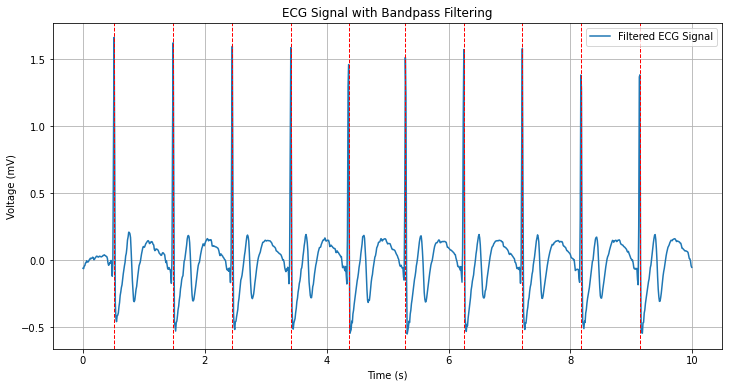

In [30]:
test_sample_number = 802

test_input_sample = X_test[test_sample_number].reshape(-1, 1) 

predictions = model.predict(test_input_sample)

# Convert the continuous predictions to binary using a threshold
index_vector = np.where(predictions > binary_threshold)[0]

highest_peak_indices = get_highest_peak_indices(predictions.flatten(), index_vector, num_timesteps)

print(highest_peak_indices)
print('Correct peak indices: ' + str(np.where(y_test[test_sample_number] == 1)[0]))

# Plot the original and filtered ECG waveforms
plt.figure(figsize=(12, 6))
plt.plot(time, test_input_sample,label='Filtered ECG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('ECG Signal with Bandpass Filtering')
plt.grid()
for peak_index in highest_peak_indices:
    plt.axvline(x=time[peak_index], color='r', linestyle='--', linewidth=1)
plt.legend()
plt.show()


Finding the QRS complex: The basic idea is to move to either side of the R-peak to find a change of sign of the derivative. To eliminate potential noise not cancelled by the filter, we set a condition of a minimum number of steps to move after the derivative where the derivative sign has to stay the same. 

In this case, the resolution is so low that the minimum number of steps is just 1, as the resolution is too low. For 500Hz we could however increase this parameter. 

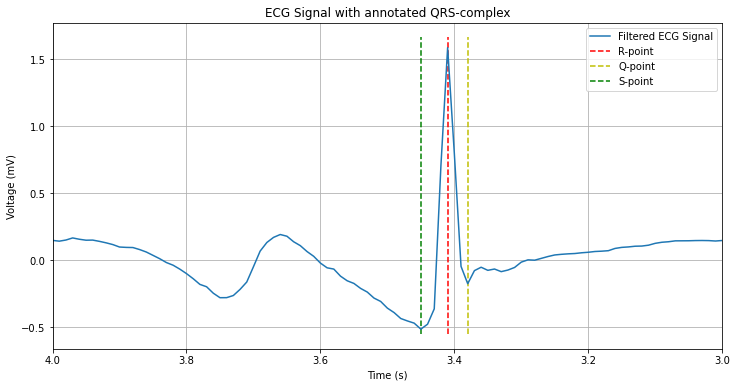

In [32]:
def find_s_and_q_points_single(ecg_signal, r_peak_index, window_size=10, min_stable_steps=1):
    q_indices = []
    s_indices = []
    
    # Move to the left of the r-peak
    left_index = r_peak_index - 1
    while left_index >= 0 and len(q_indices) < 1:
        derivative = ecg_signal[left_index] - ecg_signal[left_index - 1]
        if derivative < 0:  # Sign change detected
            q_start_index = left_index  # Store the point where derivative changed
            left_index -= 1
            stable_steps = 1  
            for i in range(1, min_stable_steps):
                if q_start_index - i < 0:
                    break
                stable_derivative = ecg_signal[q_start_index - i] - ecg_signal[q_start_index - i - 1]
                if stable_derivative < 0:
                    stable_steps += 1
                else:
                    break
            if stable_steps == min_stable_steps:
                q_indices.append(q_start_index)
        else:
            left_index -= 1
    
    # Move to the right of the r-peak
    right_index = r_peak_index + 1
    while right_index < len(ecg_signal) and len(s_indices) < 1:
        derivative = ecg_signal[right_index + 1] - ecg_signal[right_index]
        if derivative > 0:  # Sign change detected
            s_start_index = right_index  # Store the point where derivative changed
            right_index += 1
            stable_steps = 1  
            for i in range(1, min_stable_steps):
                if s_start_index + i >= len(ecg_signal):
                    break
                stable_derivative = ecg_signal[s_start_index + i + 1] - ecg_signal[s_start_index + i]
                if stable_derivative > 0:
                    stable_steps += 1
                else:
                    break
            if stable_steps == min_stable_steps:
                s_indices.append(s_start_index)
        else:
            right_index += 1
    
    return q_indices, s_indices



# Initialize lists to store r, q, and s points
all_r_points = []
all_q_points = []
all_s_points = []

# Iterate through each r peak index
for r_peak_index in highest_peak_indices:
    r = [r_peak_index]
    q, s = find_s_and_q_points_single(test_input_sample, r_peak_index)  # Separate q and s points
    all_r_points += r
    all_q_points += q
    all_s_points += s  # Use separate list for s points


# Plot the original and filtered ECG waveforms with r, q, and s points
plt.figure(figsize=(12, 6))
plt.plot(time, test_input_sample, label='Filtered ECG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('ECG Signal with annotated QRS-complex')
plt.grid()
# Set x-axis limits for zooming in
zoom_start = 4  # Starting point for zoom
zoom_end = 3    # Ending point for zoom
plt.xlim(zoom_start, zoom_end)


# Plot r points 
r_peak_times = [time[peak_index] for peak_index in all_r_points]
plt.vlines(r_peak_times, ymin=np.min(test_input_sample), ymax=np.max(test_input_sample), colors='r', linestyles='--', label='R-point')

# Plot q and s points 
q_peak_times = [time[peak_index] for peak_index in all_q_points]
plt.vlines(q_peak_times, ymin=np.min(test_input_sample), ymax=np.max(test_input_sample), colors='y', linestyles='--', label='Q-point')

s_peak_times = [time[peak_index] for peak_index in all_s_points]
plt.vlines(s_peak_times, ymin=np.min(test_input_sample), ymax=np.max(test_input_sample), colors='g', linestyles='--', label='S-point')

plt.legend()
plt.show()


Final Comments:

There are many ways to improve the performance of the model. 

One very obvious way would be to analyse all of the 12 leads separately, as they should all coincide somewhat on the r-peaks. This gives a lot more data to train on and the network can learn how the specific shape of an r-peak can look for the different leads. By comparing and verifying the predictions in each of the graphs, it gives a lot more confidence to the location of the peaks.

As mentioned, a model that could handle time series better would be beneficial. My neural network could probably be replaced with a traditional non-AI algorithm that does the same job. 

Using the sampling frequency of 500Hz instead of 100Hz can capture more detailed behaviour of the heart. This extra resolution is especially helpful in annotating the Q and S peaks through the derivative method I defined. 

Another improvement would be to include the metadata. By letting the model learn to associate different signal shapes to different metadata (ex diseases, age, device etc), it could achieve an improved prediction accuracy. 









